In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.cuda.amp import GradScaler
from torchvision.models import efficientnet_v2_m, EfficientNet_V2_M_Weights
from torch.utils.data import random_split

In [2]:
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import argparse
import os

#check gpu
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
#set hyperparameter
EPOCH = 10
pre_epoch = 0
BATCH_SIZE = 32
LR = 0.001


cuda


#### Transformer

In [3]:
# 训练数据的 transforms
transform_train = transforms.Compose([
    transforms.RandomResizedCrop(size=224, scale=(0.8, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(degrees=15),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# 测试数据的 transforms
transform_test = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])



In [4]:
data_path = "./training/"

dataset = torchvision.datasets.ImageFolder(data_path)

train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])


In [5]:
train_dataset.dataset.transform = transform_train
val_dataset.dataset.transform = transform_test

In [6]:

trainloader = torch.utils.data.DataLoader(train_dataset,
                          batch_size=BATCH_SIZE, 
                          shuffle=True)

testloader = torch.utils.data.DataLoader(val_dataset,
                          batch_size=BATCH_SIZE, 
                          shuffle=False)

import os
classes = list(os.listdir(data_path))[1:] 
classes

['butterfly',
 'cat',
 'chicken',
 'cow',
 'dog',
 'elephant',
 'horse',
 'sheep',
 'spyder',
 'squirrel']

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


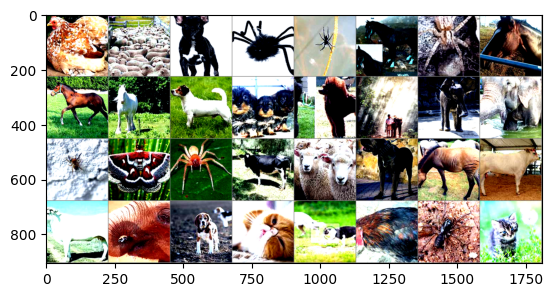

chicken sheep dog   spyder spyder horse spyder horse horse horse dog   dog   dog   elephant elephant elephant spyder butterfly spyder cow   sheep dog   horse cow   cow   elephant dog   cat   dog   chicken spyder cat  


In [7]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(BATCH_SIZE)))

# print(images.shape)

In [8]:
#define model
net = efficientnet_v2_m(weights=EfficientNet_V2_M_Weights.DEFAULT)

net.fc = nn.Linear(in_features=1280, out_features=10)
net = net.to(device)
print(net)

#define loss funtion & optimizer
optimizer = optim.Adam(net.parameters(), lr=LR)
criterion = nn.CrossEntropyLoss()

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): FusedMBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (1): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
        )
        (stochastic_depth): StochasticDepth(p=0.0, mode=row)
      )
      (1): FusedMBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (1): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  

In [9]:
from tqdm import tqdm

In [10]:
scaler = GradScaler()

#train
for epoch in range(pre_epoch, EPOCH):
    print(f"\nEpoch: {epoch + 1}")
    net.train()
    sum_loss, correct, total= 0.0, 0.0, 0.0
    
    
    with tqdm(trainloader , unit="batch" ,desc='Training') as t_epoch:
        for data in t_epoch:
            torch.cuda.empty_cache()
            #prepare dataset
            length = len(trainloader)
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            
            #forward & backward
            with torch.cuda.amp.autocast():
                outputs = net(inputs)
                loss = criterion(outputs, labels)
                
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
            
            
            #print ac & loss in each batch
            sum_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += predicted.eq(labels.data).cpu().sum()
    
    train_acc = 100.0 * correct / total
    
    #get the ac with testdataset in each epoch
    print('Waiting Test...')
    with torch.no_grad():
        correct , total = 0, 0
        
        with tqdm(testloader , unit="batch" ,desc='Testing') as t_epoch_test:
            for data in t_epoch_test:
                torch.cuda.empty_cache()
                net.eval()
                
                images, labels = data
                images, labels = images.to(device), labels.to(device)
                outputs = net(images)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum()
        
        print(f'[epoch:{epoch+1}] Loss: {loss:.3f} | Train Acc: {train_acc:.3f} | Test Acc :  {(100 * correct / total):.3f}')

print(f"Train has finished, total epoch is {EPOCH}")


Epoch: 1


Training: 100%|██████████| 629/629 [04:27<00:00,  2.35batch/s]


Waiting Test...


Testing: 100%|██████████| 158/158 [00:28<00:00,  5.63batch/s]


[epoch:1] Loss: 0.458 | Train Acc: 83.735 | Test Acc :  90.274

Epoch: 2


Training: 100%|██████████| 629/629 [04:27<00:00,  2.35batch/s]


Waiting Test...


Testing: 100%|██████████| 158/158 [00:28<00:00,  5.61batch/s]


[epoch:2] Loss: 0.242 | Train Acc: 90.418 | Test Acc :  90.493

Epoch: 3


Training: 100%|██████████| 629/629 [04:29<00:00,  2.33batch/s]


Waiting Test...


Testing: 100%|██████████| 158/158 [00:26<00:00,  6.06batch/s]


[epoch:3] Loss: 0.720 | Train Acc: 92.129 | Test Acc :  91.607

Epoch: 4


Training: 100%|██████████| 629/629 [04:34<00:00,  2.29batch/s]


Waiting Test...


Testing: 100%|██████████| 158/158 [00:29<00:00,  5.38batch/s]


[epoch:4] Loss: 0.345 | Train Acc: 93.610 | Test Acc :  92.681

Epoch: 5


Training: 100%|██████████| 629/629 [04:35<00:00,  2.28batch/s]


Waiting Test...


Testing: 100%|██████████| 158/158 [00:28<00:00,  5.54batch/s]


[epoch:5] Loss: 0.052 | Train Acc: 94.152 | Test Acc :  91.647

Epoch: 6


Training: 100%|██████████| 629/629 [04:35<00:00,  2.28batch/s]


Waiting Test...


Testing: 100%|██████████| 158/158 [00:26<00:00,  5.97batch/s]


[epoch:6] Loss: 0.471 | Train Acc: 94.938 | Test Acc :  91.527

Epoch: 7


Training: 100%|██████████| 629/629 [04:35<00:00,  2.28batch/s]


Waiting Test...


Testing: 100%|██████████| 158/158 [00:26<00:00,  5.96batch/s]


[epoch:7] Loss: 0.128 | Train Acc: 95.649 | Test Acc :  92.184

Epoch: 8


Training: 100%|██████████| 629/629 [04:37<00:00,  2.27batch/s]


Waiting Test...


Testing: 100%|██████████| 158/158 [00:34<00:00,  4.58batch/s]


[epoch:8] Loss: 0.240 | Train Acc: 95.724 | Test Acc :  90.712

Epoch: 9


Training: 100%|██████████| 629/629 [04:44<00:00,  2.21batch/s]


Waiting Test...


Testing: 100%|██████████| 158/158 [00:25<00:00,  6.16batch/s]


[epoch:9] Loss: 0.035 | Train Acc: 96.012 | Test Acc :  90.215

Epoch: 10


Training: 100%|██████████| 629/629 [04:23<00:00,  2.39batch/s]


Waiting Test...


Testing: 100%|██████████| 158/158 [00:26<00:00,  5.93batch/s]

[epoch:10] Loss: 0.473 | Train Acc: 96.529 | Test Acc :  91.468
Train has finished, total epoch is 10


In [11]:
PATH = './HW4_ef_net.pth'
torch.save(net.state_dict(), PATH)

In [12]:
MODEL_PATH = './HW4_ef_net.model'
torch.save(net, MODEL_PATH)

In [13]:
torch.cuda.empty_cache()